Eu não usei todas essas bibliotecas, mas eu importo só pra manter na memória como chama cada uma delas...

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold,GridSearchCV
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import ridge_regression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier, MLPRegressor
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error, r2_score
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df = pd.read_csv('winequality-red.csv')

# Avaliando NaNs, Infs, DTypes, e df.shape em uma só linha!

In [3]:
ProfileReport(df,minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Por meio da análise desse gráfico, foi possível realizar as seguintes observações:
* Nenhum valor NaN ou Inf em todo o DataSet (Extremamente limpo!)
* Todas as features são Quantitativas Contínuas! (Não há a necessidade de realizar nenhuma dummyzação, ou transformação de variáveis qualitativas ordinais em quantitativas discretas, pois elas não existem)
* A variável de interesse é Quantitativa Discreta! 
    * Opções: Regressão, Classificação, ou Clusterização (Devido também à pouca quantidade de dimensões presentes). Clusterização seria bem menos recomendado mas também é uma possibilidade! Veremos mais sobre isso futuramente.
* 11 Features e 1599 observações (Quantidade de variáveis é mais do que o suficiente para realizar aplicar um bom modelo!) - Questão B

# Análise de Outliers e Distribuição das features

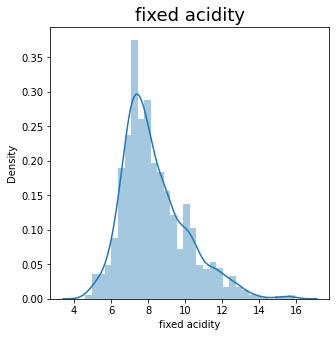

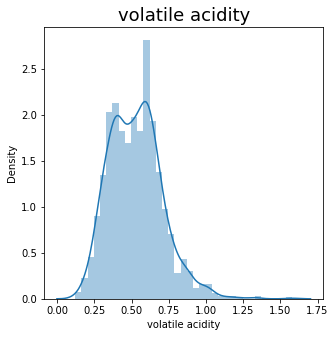

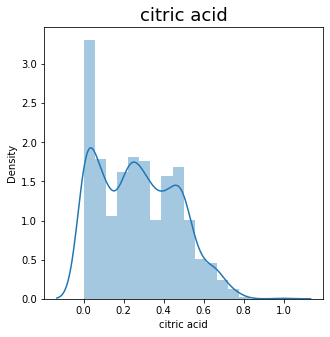

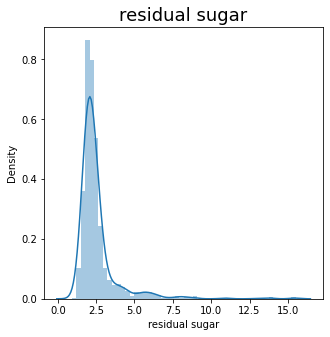

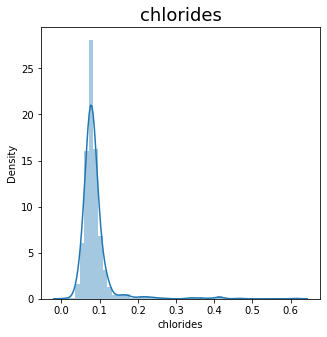

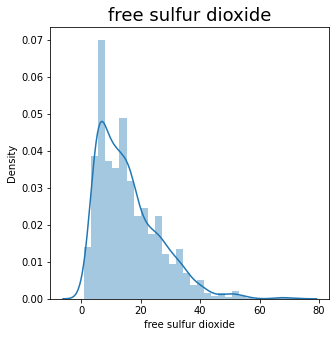

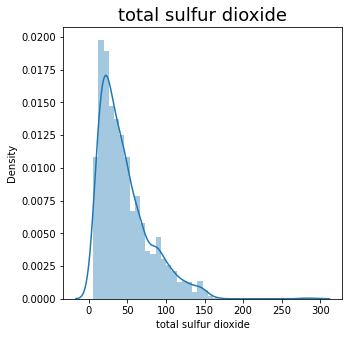

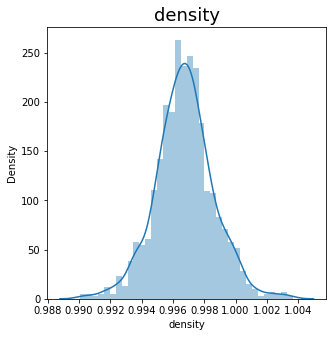

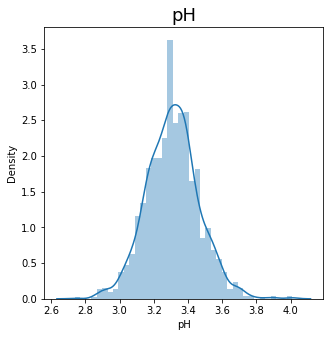

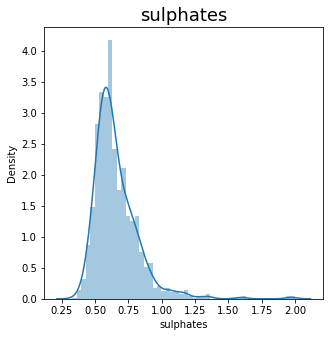

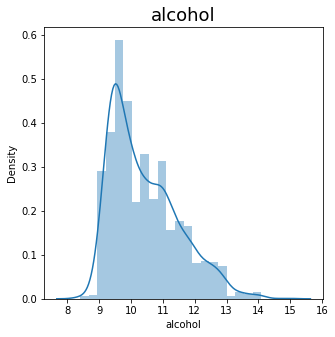

In [21]:
for i in df.drop(columns='quality').columns:
    plt.figure(figsize=(5,5))
    plt.title(i,fontsize =18)
    sns.distplot(df[i])
    plt.show()

Todas as features aparentam seguir uma distribuição normal. Obviamente o nível de assimetria (Skewness) e curtose (Kurtosis) varia de variável para variável, e nunca será perfeito, mas no geral TODAS AS FEATURES aparentam seguir uma normal, o que já é muito bom, e o esperado para variáveis quantitativas.

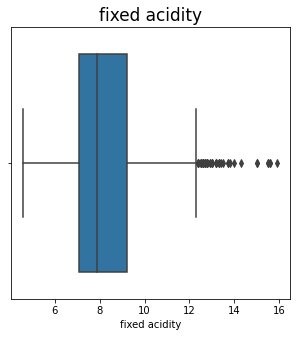

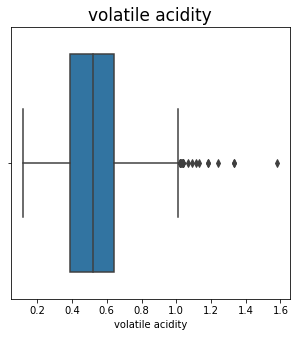

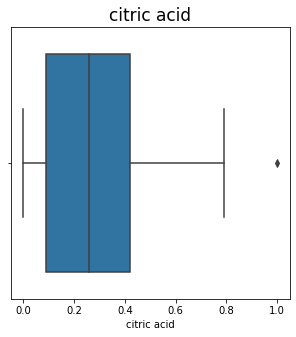

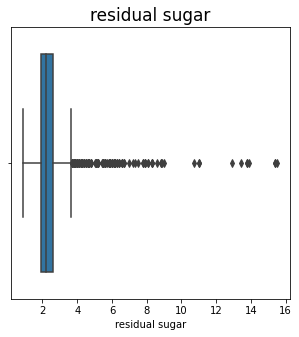

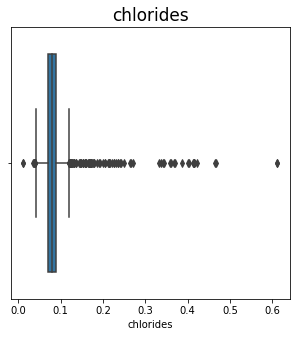

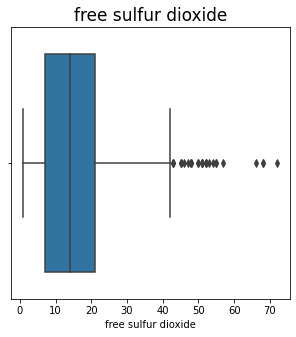

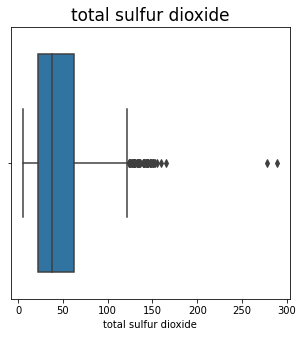

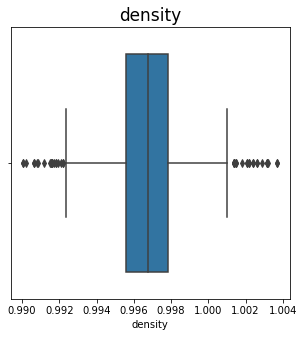

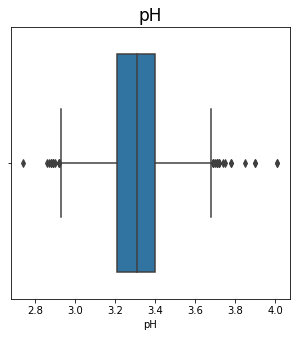

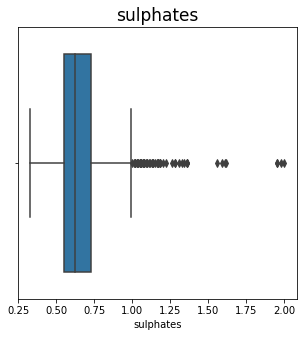

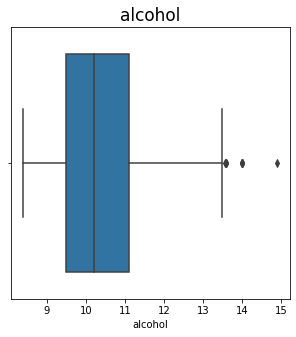

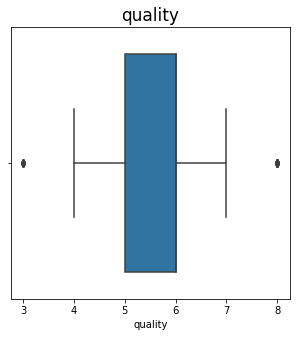

In [20]:
for i in df.columns:
    plt.figure(figsize=(5,5))
    plt.title(i,fontsize =17)
    sns.boxplot(df[i])
    plt.show()

Por meio dos boxplots, foi possível verificar a presença forte de Outliers em muitas das features. Apesar disso, é muito improvável que esses outliers tenham sido resultado de algum erro de cálculo ou no momento de input dos valores, pois os seus valores não são absurdos demais (Ex: Um boxplot cujo intervalo interquartil, ou "corpo" do boxplot é quase invisível devido aos outliers), portanto, não se recomenda eliminar nenhuma dessas variáveis! É necessário uma outra metodologia para tratar os dados que falaremos mais a respeito futuramente...

### Vamos sair dos gráficos e observar os valores por si!

In [6]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [7]:
df.drop(columns='quality').describe(percentiles=[0.1,0.25,0.75,0.9])

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00
mean,8.32,0.53,0.27,2.54,0.09,15.87,46.47,1.00,3.31,0.66,10.42
std,1.74,0.18,0.19,1.41,0.05,10.46,32.90,0.00,0.15,0.17,1.07
min,4.60,0.12,0.00,0.90,0.01,1.00,6.00,0.99,2.74,0.33,8.40
10%,6.50,0.31,0.01,1.70,0.06,5.00,14.00,0.99,3.12,0.50,9.30
25%,7.10,0.39,0.09,1.90,0.07,7.00,22.00,1.00,3.21,0.55,9.50
50%,7.90,0.52,0.26,2.20,0.08,14.00,38.00,1.00,3.31,0.62,10.20
75%,9.20,0.64,0.42,2.60,0.09,21.00,62.00,1.00,3.40,0.73,11.10
90%,10.70,0.74,0.52,3.60,0.11,31.00,93.20,1.00,3.51,0.85,12.00
max,15.90,1.58,1.00,15.50,0.61,72.00,289.00,1.00,4.01,2.00,14.90


* Em algumas variáveis, ao compararmos o 90º percentil com os seus valores máximos, verificamos distorções significativas! Isso indica a presença forte de outliers nelas. (Porém não são tãaaao absurdas assim...)
* Outra observação válida seria o fato de que as variáveis apresentam suas médias muito próximas das suas medianas, o que é também uma excelente métrica para verificar a presença ou não de Outliers nos dados, que distorceriam a média BASTANTE se os outliers realmente fossem absurdos. 
* Além disso, verifica-se uma significativa diferença nos valores mínimos e máximos para cada uma das variáveis, o que indica que elas estão em diferentes escalas, e isso exigirá algum tipo de normalização. Opções: MinMaxScaler, StandardScaler. Selecionaremos o StandardScaler!
  * MinMaxScaler força todas as variáveis a assumirem valores entre 0 e 1.
  * StandardScaler fornece a todas as variáveis um valor com base em seus desvios padrões, bom para dados com muitos Outliers, os quais poderiam distorcer os dados no MinMaxScaler

# Analisando se os dados estão desbalanceados

---------------------------------------- Analisando se os dados estão desbalanceados ----------------------------------------


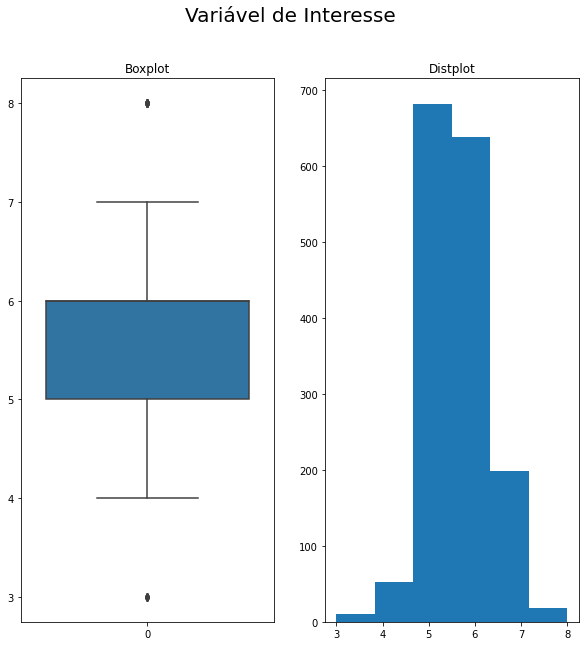

---------------------------------------- Quantidade de Observações Para Cada Dimensão ----------------------------------------


,quality
5,681
6,638
7,199
4,53
8,18
3,10


In [8]:
print('-'*40 +' Analisando se os dados estão desbalanceados '+ '-'*40)
fig, [axs1,axs2] = plt.subplots(1,2,figsize=(10,10))
fig.suptitle('Variável de Interesse',fontsize=20)
axs1.title.set_text('Boxplot')
sns.boxplot(data = df['quality'],ax=axs1)
axs2.title.set_text('Distplot')
axs2.hist(df['quality'],bins=6)
plt.show()
print('-'*40 +' Quantidade de Observações Para Cada Dimensão '+ '-'*40)

pd.DataFrame(df['quality'].value_counts())

### Observações:
* A variável de interesse, também aparenta apresentar uma distribuição normal (Maior concentração de observações entre os valores 5 e 6)
* Possui uma elevada dimensionalidade (6 valores possíveis)
* Não está bem balanceada no momento (Não possui a mesma quantidade de observações para cada dimensão).

# Seleção de Modelos!

A variável de interesse é uma variável quantitativa discreta, o que significa que o problema poderá ser resolvido por meio de 2 diferentes modelos: Regressão (Com adaptação), ou Classificação.

### Para a modelagem teremos 3 caminhos possíveis:
* #### Modelos de Classificação.
    * Descrição: Geralmente aplicados quando JÁ SABEMOS OS GRUPOS QUE EXISTEM e queremos atribuir um grupo para cada observação nova.
    * Vantagens: Resultados mais claros, pois problemas de classificação podem envolver variáveis qualitativas nominais, qualitativas ordinais, ou quantitativas discretas.
    * Desvantagens: Dados extremamente desbalanceados, o que exigirá um Oversampling para ser comparável aos modelos de regressão.  
    * Melhores modelos à nossa disposição: KNN (Nearest Neighbours), Naive Bayes, RandomForestClassifier, GradientBoostingClassifier, MLPClassifier.
    * Métricas de Desempenho (Serão utilizados Tanto para classificação quanto para Clusterização): Acurácia (Inaconselhável para dados desbalanceados), F1Score, Precision (Foco nos falsos positivos), e Recall (Foco nos falsos negativos)
* #### Modelos de Regressão.
    * Descrição: Realizados para obter valores numéricos contínuos para uma variável de interesse de acordo com valores de uma série de features.
    * Vantagens: Dados desbalanceados não afetarão o resultado final, além disso a variável de interesse, na teoria deveria variar de 0 a 10, e apenas modelos de regressão poderão verificar se uma nova observação poderá estar acima de 8 ou abaixo de 3, que são grupos que não foram ainda verificados e não poderiam ser mensurados por Classificação ou Clustering!!
    * Desvantagens: Problemas de regressão envolvem variáveis quantitativas CONTÍNUAS! A variável de interesse se trata de uma variável quantitativa DISCRETA, porém como os valores gerado por esses algorítmos são contínuos, os resultados não serão claros como os dos modelos de classificação, isso exigirá uma adaptação, que será feita elevando ou reduzindo ao valor inteiro mais próximo (Ex: 4,6 vira 5, 4,2 vira 4).
    * Melhores modelos à nossa disposição para teste: RandomForestRegressor, GradientBoostingRegressor, MLPRegressor, 
    * Métricas de Desempenho: MSQE (Mean Squared Error), MAE (Mean Absolute Error), MAPE (Mean Absolute Percentage Error).

### Tuning dos Modelos:

Será feito por meio de:

* Cross-Validation --> Para decidir o modelo principal a se utilizar (Ex: Random Forest, Naive Bayes, etc)
* HiperParameter Tuning --> GridSearch ou BayesSearch (Vão testando vários hiperparâmetros e vendo quais apresentam as melhores métricas de desempenho), feito só depois que JÁ DECIDIMOS O MODELO PRINCIPAL ESCOLHIDO (Ex: verificar a partir de qual nó seria melhor podar as árvores de decisão no Random Forest, etc.)

### Etapa final:

Compararemos os modelos de classificação e clusterização por meio de suas métricas de desempenho. No caso dos modelos de regressão, como suas métricas são diferente das dos demais modelos, precisa-se usar o bom senso para verificar qual deles será mais adequado ao nosso caso (Caso um ou outro modelo estaja MUITO ruim perceptivelmente, também pode-se optar por descartar ele sem ter que pensar muito).

# Parte 2: PF

# Modelagem

In [9]:
from datetime import datetime as dt
# Train Test Split
X = df.drop(columns='quality')
y = df['quality']

kf = KFold(n_splits=10)
kf.get_n_splits(X)

models = {
    'Random Forest Classifier': RandomForestClassifier(),
    'XGBoost Classifier':XGBClassifier(),
    'Naive Bayes Classifier':GaussianNB(),
    'MLP Classifier':MLPClassifier(),
    'Gradient Boosting Classifier':GradientBoostingClassifier(),
    'Random Forest Regressor': RandomForestRegressor(),
    'MLP Regressor':MLPRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'Linear Regressor': LinearRegression(),
}

results = {}
agora = dt.now()

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Oversampling

    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    y_train = y_train_res
    
    # Standard Scaler
    scaler = StandardScaler().fit(X_train_res,X_test)

    X_train = pd.DataFrame(scaler.fit_transform(X_train_res),columns=X_train.columns)
    X_test = pd.DataFrame(scaler.fit_transform(X_test),columns=X_test.columns)
    
    results[f'{test_index[0]} - {test_index[-1]}'] = {}
    
    for keys, values in models.items():

        reg_ou_class = keys.split()
        
        if reg_ou_class[-1] == 'Classifier':
            y_train = y_train - y_train.min()
            y_test = y_test - y_test.min()
            
        
        predictor = values.fit(X_train,y_train)
        estimations = predictor.predict(X_test)
        
        
        if reg_ou_class[-1] == 'Regressor':
            l = []
            for estimation in estimations:
                if estimation - int(estimation) > 0.5:
                    l.append(int(estimation) + 1)
                else:
                    l.append(int(estimation))
            estimations = l

        scores = {keys: {'Accuracy Score': accuracy_score(estimations,y_test),
                         'Precision Score': precision_score(estimations,y_test,average='weighted'),
                         'Recall Score': recall_score(estimations,y_test,average='weighted'),
                         'F1 Score': f1_score(estimations,y_test,average='weighted'),
                         'Confusion Matrix': confusion_matrix(estimations,y_test),
                         'CM Shape':confusion_matrix(estimations,y_test).shape,
                         'Mean Squared Error':mean_squared_error(estimations,y_test),
                         'R2 Score':r2_score(estimations,y_test)
                        }
                 }
        
        results[f'{test_index[0]} - {test_index[-1]}'].update(scores)
        
    print('\r', f'CVs Completos: {test_index[-1]/len(y)*100:.2f}%\t CVs Restantes: {int(10 - test_index[-1]/len(y)*10)} \t Tempo que já demorou: {dt.now()-agora}' + '\t'*30, end='\r')
        

# Comparação entre modelos

In [10]:
parameters ={'Accuracy Score':{},'Precision Score':{},'Recall Score':{},'F1 Score':{},'R2 Score':{},'Mean Squared Error':{},'CM Shape':{}}
for item,value in parameters.items():
    models = {}
    for j in results[list(results.keys())[0]].keys():
        mean = []
        for i in results.keys():
            mean.append(results[i][j][item])
        if item != 'CM Shape':
            models.update({j:np.mean(mean)})
        else:
            models.update({j:mean})
    parameters[item].update(models)    
resultados = pd.DataFrame(parameters)

parameters['F1 Score']

{'Random Forest Classifier': 0.2995972746039394,
 'XGBoost Classifier': 0.30202517844714116,
 'Naive Bayes Classifier': 0.20217156600822256,
 'MLP Classifier': 0.27764551488710054,
 'Gradient Boosting Classifier': 0.26574129973250604,
 'Random Forest Regressor': 0.37399237355909826,
 'MLP Regressor': 0.319334685396091,
 'Gradient Boosting Regressor': 0.3156966247074312,
 'Linear Regressor': 0.2910268125223076}

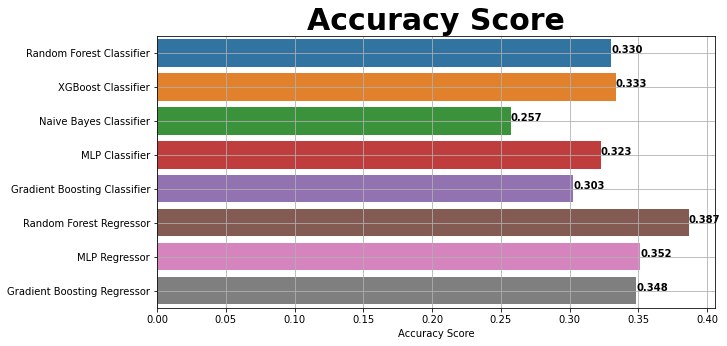

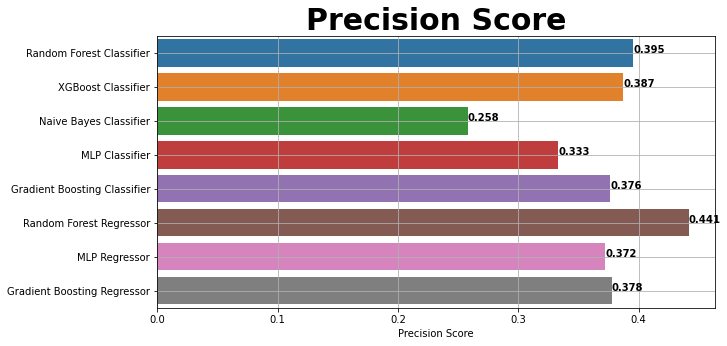

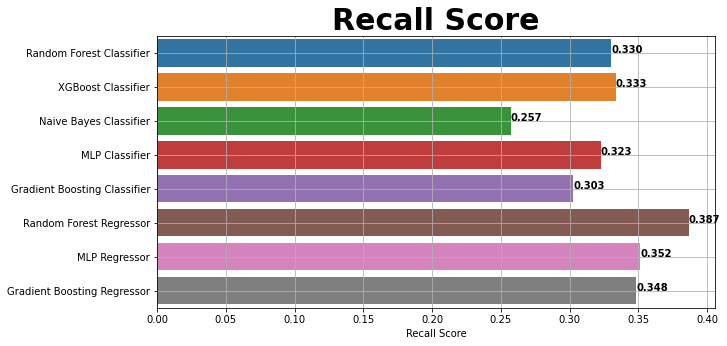

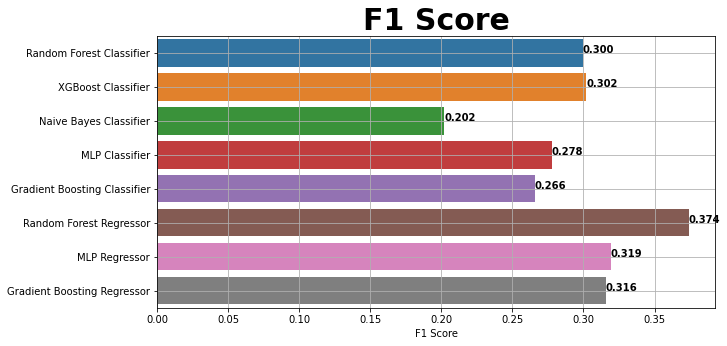

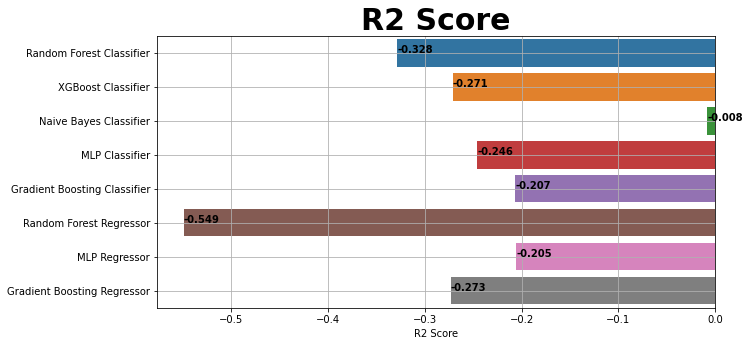

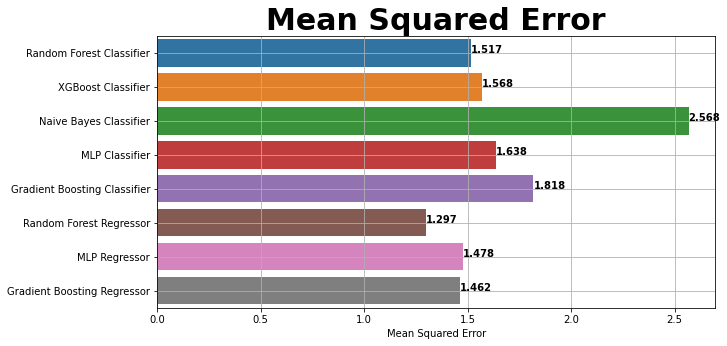

In [11]:
for i in resultados.drop(columns='CM Shape').columns:
    plt.figure(figsize=(10,5))
    plt.title(i,fontsize=30,fontweight='bold')
    sns.barplot(resultados[i][:-1],resultados.index[:-1])
    for j in range(len(resultados.index[:-1])):
        plt.text(resultados[i][:-1][j],j,format(resultados[i][:-1][j],'.3f'),fontfamily='DejaVu Sans',fontweight='bold')
    plt.grid()
    plt.show()

## Modelo Escolhido: Random Forest Regressor!

# Tuning de Hiperparâmetros

### Vai ser necessário desenvolver uma função específica para realizar o Grid Search!

In [12]:
from datetime import datetime as dt
import warnings 
warnings.filterwarnings('ignore')

kf = KFold(n_splits=10)
kf.get_n_splits(X)

grid = {
    'n_estimators': [75,85,100,115,125],
    'min_samples_split' : [2,4,8],
    'max_depth':[None, 1,2,3,4]
}

    
X = df.drop(columns='quality')
y = df['quality']

results = {}
agora = dt.now()

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Oversampling
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    y_train = y_train_res

    # Standard Scaler
    scaler = StandardScaler().fit(X_train_res,X_test)
    X_train = pd.DataFrame(scaler.fit_transform(X_train_res),columns=X_train.columns)
    X_test = pd.DataFrame(scaler.fit_transform(X_test),columns=X_test.columns)
    
    results[f'{test_index[0]} - {test_index[-1]}'] = {}

    for i, v in enumerate(grid['n_estimators']):
        for i1, v1 in enumerate(grid['min_samples_split']):
            for i2, v2 in enumerate(grid['max_depth']):
                predictions = RandomForestRegressor(n_estimators=v,min_samples_split=v1,max_depth = v2)
                final_predictions = predictions.fit(X_train,y_train)
                final_predictions = final_predictions.predict(X_test)
                l = []
                for final_prediction in final_predictions:
                    if final_prediction - int(final_prediction) > 0.5:
                        l.append(int(final_prediction) + 1)
                    else:
                        l.append(int(final_prediction))
                final_predictions = l

                scores = {f'n_estimators = {v} min_samples_split = {v1} max_depth = {v2}':
                           {'Accuracy Score': accuracy_score(final_predictions,y_test),
                           'Precision Score': precision_score(final_predictions,y_test,average='weighted'),
                           'Recall Score': recall_score(final_predictions,y_test, average = 'weighted'),
                           'F1 Score': f1_score(final_predictions,y_test,average='weighted'),
                           'R2 Score': r2_score(final_predictions,y_test),
                           'MSQE': mean_squared_error(final_predictions,y_test)
                           }
                          }
                
                results[f'{test_index[0]} - {test_index[-1]}'].update(scores)            
    
    print('\r', f'CVs Completos: {test_index[-1]/len(y)*100:.2f}%\t CVs Restantes: {int(10 - test_index[-1]/len(y)*10)} \t Tempo que já demorou: {dt.now()-agora}' + '\t'*30, end='\r')

In [13]:
parameters ={'Accuracy Score':{},'Precision Score':{},'Recall Score':{},'F1 Score':{},'R2 Score':{},'MSQE':{}}
for item,value in parameters.items():
    models = {}
    for j in results[list(results.keys())[0]].keys():
        mean = []
        for i in results.keys():
            mean.append(results[i][j][item])
        models.update({j:np.mean(mean)})
    parameters[item].update(models)
resultados_tuning = pd.DataFrame(parameters).rename(columns={'MSQE':'Mean Squared Error'})

In [14]:
resultados_tuning.sort_values(by='F1 Score',ascending=False).head(13)

,Accuracy Score,Precision Score,Recall Score,F1 Score,R2 Score,Mean Squared Error
n_estimators = 115 min_samples_split = 8 max_depth = None,0.51,0.51,0.51,0.49,0.02,0.82
n_estimators = 100 min_samples_split = 4 max_depth = None,0.50,0.50,0.50,0.48,0.01,0.81
n_estimators = 100 min_samples_split = 8 max_depth = None,0.50,0.50,0.50,0.48,-0.00,0.82
n_estimators = 85 min_samples_split = 2 max_depth = None,0.50,0.50,0.50,0.48,0.01,0.82
n_estimators = 85 min_samples_split = 4 max_depth = None,0.50,0.50,0.50,0.48,0.01,0.82
n_estimators = 125 min_samples_split = 8 max_depth = None,0.50,0.50,0.50,0.48,0.02,0.81
n_estimators = 75 min_samples_split = 2 max_depth = None,0.49,0.50,0.49,0.48,0.02,0.82
n_estimators = 125 min_samples_split = 2 max_depth = None,0.49,0.49,0.49,0.48,0.02,0.81
n_estimators = 85 min_samples_split = 8 max_depth = None,0.49,0.50,0.49,0.48,0.03,0.82
n_estimators = 115 min_samples_split = 4 max_depth = None,0.49,0.49,0.49,0.48,0.01,0.83


### Default Random Forest Regressor vs Tuned Random Forest Regressor

findfont: Font family ['comicsans'] not found. Falling back to DejaVu Sans.


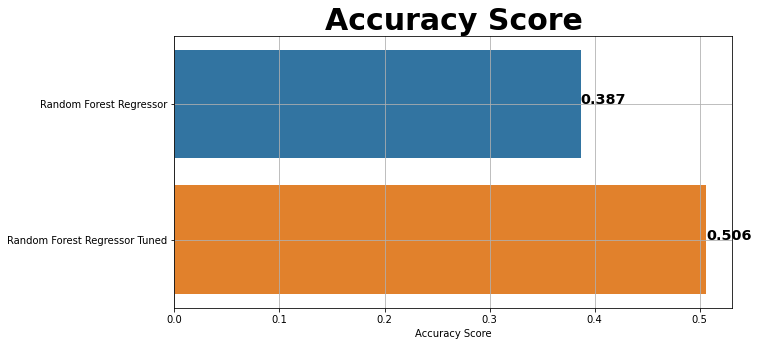

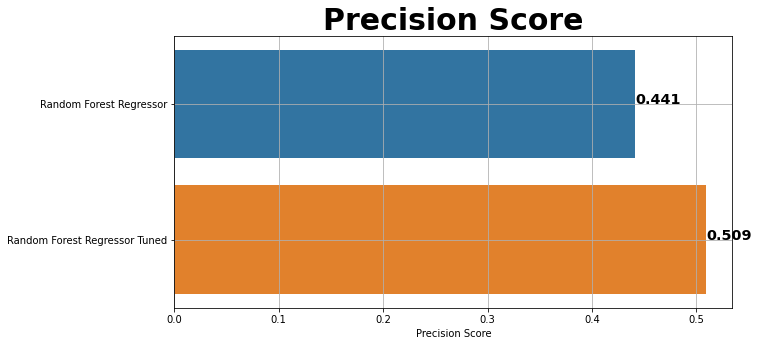

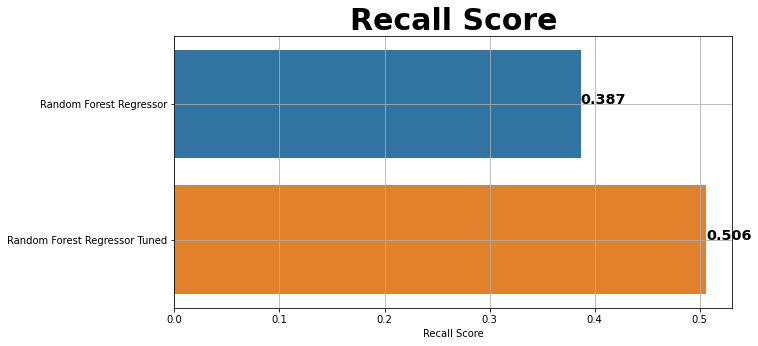

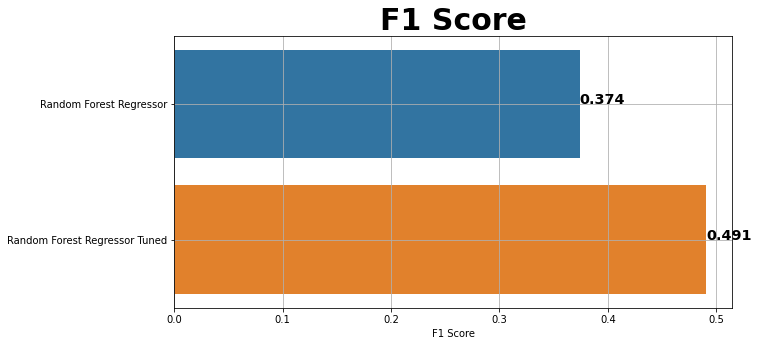

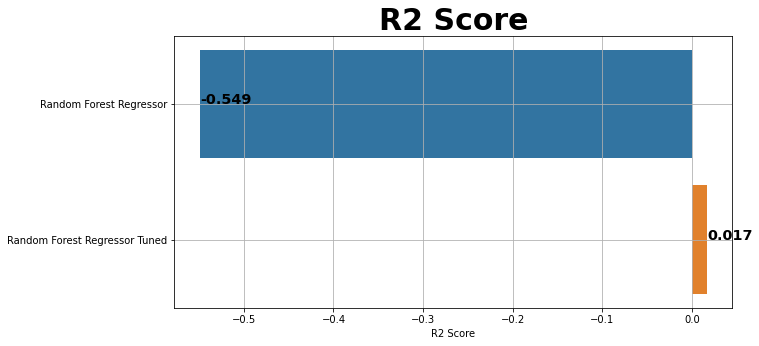

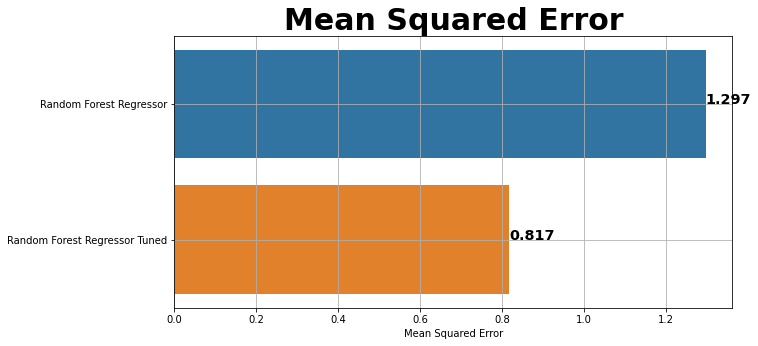

In [15]:
resultados.loc['Random Forest Regressor Tuned'] = resultados_tuning\
.loc[resultados_tuning.sort_values(by='F1 Score', ascending = False).index[0]]

for i in resultados.drop(columns='CM Shape').columns:
    plt.figure(figsize=(10,5))
    plt.title(i,fontsize=30,fontweight='bold')
    sns.barplot(resultados[i][['Random Forest Regressor','Random Forest Regressor Tuned']],
                                  ['Random Forest Regressor','Random Forest Regressor Tuned'])
    
    resultados1 = resultados[i][['Random Forest Regressor','Random Forest Regressor Tuned']]
    for index,value in enumerate(list(resultados1)):
        plt.text(value,index,format(value,'.3f'),fontweight='bold',fontsize='x-large',fontfamily='comicsans')
    plt.grid()
    plt.show()

### All other models vs Tuned Random Forest Regressor

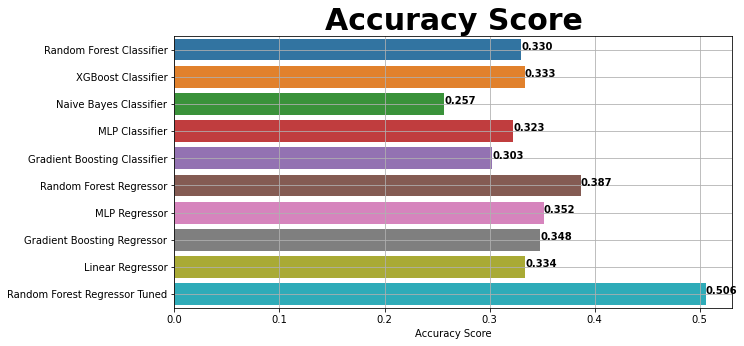

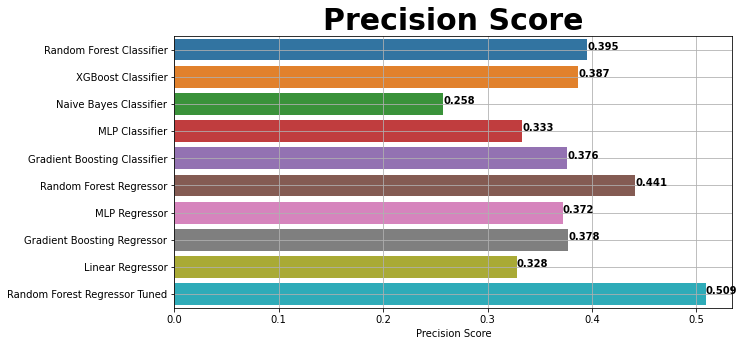

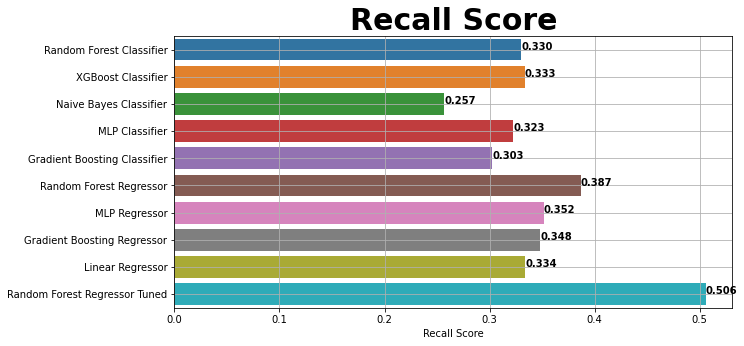

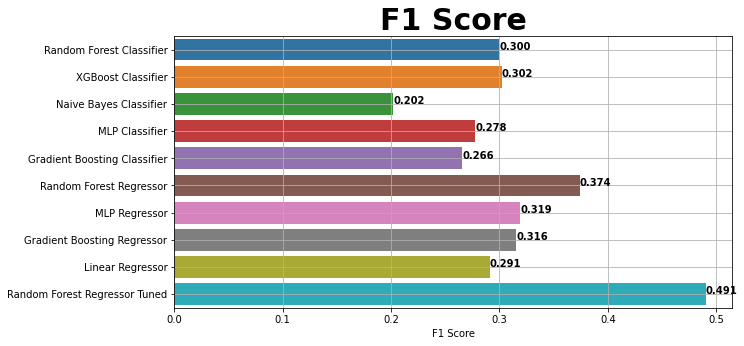

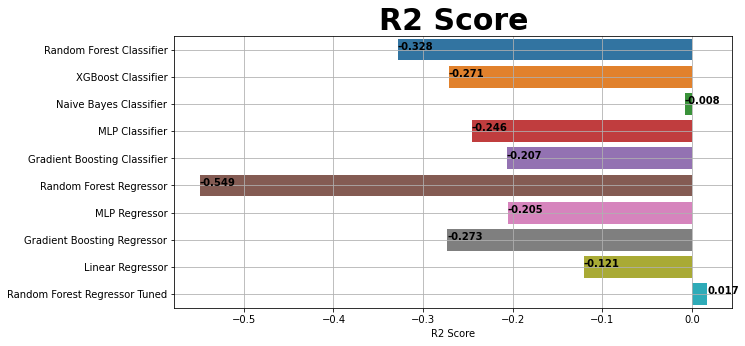

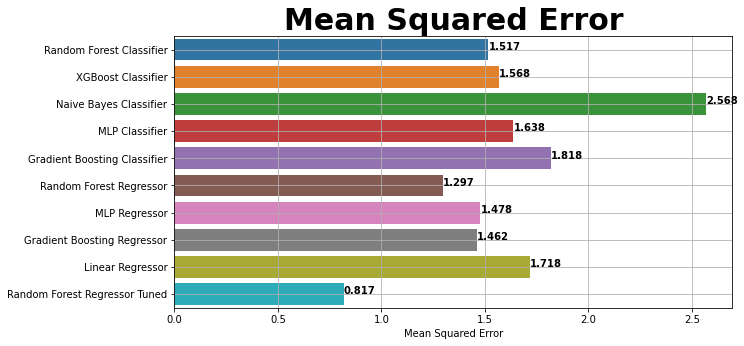

In [16]:
from matplotlib.axes import Axes
for i in resultados.drop(columns='CM Shape').columns:
    plt.figure(figsize=(10,5))
    plt.title(i,fontsize=30,fontweight='bold')
    sns.barplot(resultados[i],resultados.index)
    for j in range(len(resultados.index)):
        plt.text(resultados[i][j],j,format(resultados[i][j],'.3f'),fontfamily='DejaVu Sans',fontweight='bold')
    plt.grid()
    plt.show()

### OverSampling Result

Text(0, 0.5, 'Quantidade de Indivíduos')

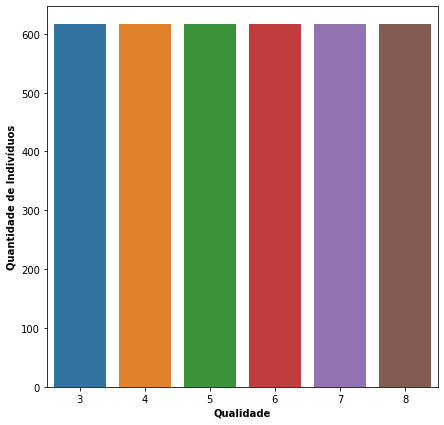

In [17]:
plt.figure(figsize=(7,7))
fig.patch.set_facecolor('white')
sns.barplot(list(range(3,9)),pd.concat([X_train,y_train],1)['quality'].value_counts())
plt.xlabel('Qualidade',fontweight='bold')
plt.ylabel('Quantidade de Indivíduos',fontweight='bold')

# Feature Importances

### Quais das features impactam mais a variável resposta? Esse efeito é positivo ou negativo?
##### Não realizamos o cross-validation pra verificar isso, mas seria uma excelente opção!

In [18]:
df.corr()[['quality']].drop(index='quality').sort_values(by='quality')

,quality
volatile acidity,-0.39
total sulfur dioxide,-0.19
density,-0.17
chlorides,-0.13
pH,-0.06
free sulfur dioxide,-0.05
residual sugar,0.01
fixed acidity,0.12
citric acid,0.23
sulphates,0.25


findfont: Font family ['fantasy'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'fantasy' not found because none of the following families were found: Chicago, Charcoal, Impact, Western, Humor Sans, xkcd, fantasy
findfont: Font family ['fantasy'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'fantasy' not found because none of the following families were found: Chicago, Charcoal, Impact, Western, Humor Sans, xkcd, fantasy


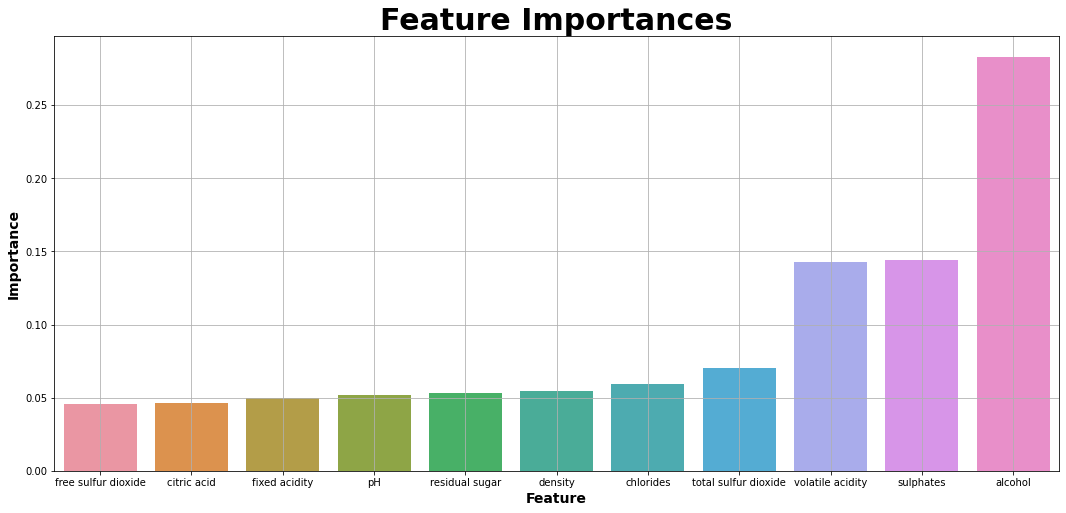

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

predictions3 = RandomForestRegressor(n_estimators=115,min_samples_split=8,max_depth=None).fit(X_train,y_train)
importances = predictions3.feature_importances_
importances = pd.concat([pd.DataFrame(importances,columns=['importances']),pd.DataFrame(X_train.columns,columns=['feature'])],1)
plt.figure(figsize=(18,8))
plt.title('Feature Importances',fontsize=30,fontfamily='fantasy',fontweight='bold')
sns.barplot(importances.sort_values(by='importances')['feature'],importances.sort_values(by='importances')['importances'])
plt.ylabel('Importance',fontweight='bold',fontfamily='fantasy',fontsize=14)
plt.xlabel('Feature',fontweight='bold',fontfamily='fantasy',fontsize=14)
plt.grid()
plt.show()